In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 628ms/step - loss: 0.0356
Average validation loss: 0.6896296143531799
4/4 [==============================] - 7s 642ms/step - loss: 0.0356 - val_loss: 0.6896
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 823ms/step - loss: 0.0258 - val_loss: 0.6896
Average validation loss: 0.5935773253440857
4/4 [==============================] - 10s 837ms/step - loss: 0.0258 - val_loss: 0.6416
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 13s 806ms/step - loss: 0.0197 - val_loss: 0.6416
Average validation loss: 0.5348008871078491
4/4 [==============================] - 13s 821ms/step - loss: 0.0197 - val_lo

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 798ms/step - loss: 0.0011
Average validation loss: 0.003037807415239513
8/8 [==============================] - 6s 813ms/step - loss: 0.0011 - val_loss: 0.0030
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 770ms/step - loss: 0.0010 - val_loss: 0.0030
Average validation loss: 7.433470372575357e-08
8/8 [==============================] - 13s 785ms/step - loss: 0.0010 - val_loss: 0.0015
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 19s 764ms/step - loss: 0.0010 - val_loss: 0.0015
Average validation loss: 9.391904313815758e-06
8/8 [==============================] - 19s 781ms/step - loss: 0.001

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 10s 812ms/step - loss: 0.0011
Average validation loss: 0.0285417337436229
12/12 [==============================] - 10s 826ms/step - loss: 0.0011 - val_loss: 0.0285
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 19s 772ms/step - loss: 0.0011 - val_loss: 0.0285
Average validation loss: 0.028494753933046013
12/12 [==============================] - 19s 787ms/step - loss: 0.0011 - val_loss: 0.0285
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 29s 767ms/step - loss: 0.0011 - val_loss: 0.0285
Average validation loss: 0.022929605407019455
12/12 [==============================] - 29s 781ms/step - l

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 13s 796ms/step - loss: 9.7326e-04
Average validation loss: 0.06381519325077534
16/16 [==============================] - 13s 809ms/step - loss: 9.7326e-04 - val_loss: 0.0638
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 26s 807ms/step - loss: 9.5833e-04 - val_loss: 0.0638
Average validation loss: 0.044074506033211946
16/16 [==============================] - 26s 821ms/step - loss: 9.5833e-04 - val_loss: 0.0539
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 39s 778ms/step - loss: 9.3272e-04 - val_loss: 0.0539
Average validation loss: 0.041224326472729445
16/16 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 16s 785ms/step - loss: 8.3179e-04
Average validation loss: 0.17820577919483185
20/20 [==============================] - 16s 798ms/step - loss: 8.3179e-04 - val_loss: 0.1782
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 32s 774ms/step - loss: 7.3748e-04 - val_loss: 0.1782
Average validation loss: 0.07926544770598412
20/20 [==============================] - 32s 786ms/step - loss: 7.3748e-04 - val_loss: 0.1287
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 47s 777ms/step - loss: 6.9466e-04 - val_loss: 0.1287
Average validation loss: 0.5959208965301513
20/20 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 19s 779ms/step - loss: 7.1779e-04
Average validation loss: 0.21130829056104025
24/24 [==============================] - 19s 792ms/step - loss: 7.1779e-04 - val_loss: 0.2113
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 38s 780ms/step - loss: 6.3403e-04 - val_loss: 0.2113
Average validation loss: 0.15299364427725473
24/24 [==============================] - 38s 792ms/step - loss: 6.3403e-04 - val_loss: 0.1822
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 57s 780ms/step - loss: 6.0015e-04 - val_loss: 0.1822
Average validation loss: 0.0992967610557874
24/24 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 31s 779ms/step - loss: 8.4988e-04
Average validation loss: 0.05270614642649889
40/40 [==============================] - 32s 791ms/step - loss: 8.4988e-04 - val_loss: 0.0527
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 63s 780ms/step - loss: 8.1955e-04 - val_loss: 0.0527
Average validation loss: 0.09530751630663872
40/40 [==============================] - 63s 792ms/step - loss: 8.1955e-04 - val_loss: 0.0740
Epoch 3/10
40/40 [==============================] - 95s 786ms/step - loss: 8.8040e-04 - val_loss: 0.0740
Average validation loss: 0.07835696674883366
40/40 [==============================] - 95s 797ms/step - loss: 8.8040e-04 - val_loss: 0.0755
Epoch 4/10
40/40 [==============================] - 127s 784ms/step - loss: 8.7821e-04 - val_loss: 0.0755
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 37s 777ms/step - loss: 6.4675e-04
Average validation loss: 1.0863324602444966
48/48 [==============================] - 38s 790ms/step - loss: 6.4675e-04 - val_loss: 1.0863
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 76s 787ms/step - loss: 5.5668e-04 - val_loss: 1.0863
Average validation loss: 0.06772365421056747
48/48 [==============================] - 77s 800ms/step - loss: 5.5668e-04 - val_loss: 0.5770
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 115s 790ms/step - loss: 5.2566e-04 - val_loss: 0.5770
Average validation loss: 0.06583232153207064
48/48 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 44s 785ms/step - loss: 5.9629e-04
Average validation loss: 0.07749774245478745
56/56 [==============================] - 45s 797ms/step - loss: 5.9629e-04 - val_loss: 0.0775
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 89s 785ms/step - loss: 5.0471e-04 - val_loss: 0.0775
Average validation loss: 0.07042885342629493
56/56 [==============================] - 90s 798ms/step - loss: 5.0471e-04 - val_loss: 0.0740
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 133s 782ms/step - loss: 4.5806e-04 - val_loss: 0.0740
Average validation loss: 0.07227659446860864
56/56 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 50s 782ms/step - loss: 5.2364e-04
Average validation loss: 0.057556009120162344
64/64 [==============================] - 51s 795ms/step - loss: 5.2364e-04 - val_loss: 0.0576
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 101s 782ms/step - loss: 4.6644e-04 - val_loss: 0.0576
Average validation loss: 0.08183203291264363
64/64 [==============================] - 102s 794ms/step - loss: 4.6644e-04 - val_loss: 0.0697
Epoch 3/10
64/64 [==============================] - 152s 782ms/step - loss: 4.1713e-04 - val_loss: 0.0697
Average validation loss: 0.059214710199739784
64/64 [==============================] - 153s 794ms/step - loss: 4.1713e-04 - val_loss: 0.0662
Epoch 4/10
64/64 [==============================] - 203s 781ms/step - loss: 3.9159e-04 - val_loss: 0.0662
Average va

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 57s 786ms/step - loss: 4.2954e-04
Average validation loss: 0.085264065509869
72/72 [==============================] - 58s 798ms/step - loss: 4.2954e-04 - val_loss: 0.0853
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 114s 780ms/step - loss: 3.6081e-04 - val_loss: 0.0853
Average validation loss: 0.0849370298286279
72/72 [==============================] - 115s 793ms/step - loss: 3.6081e-04 - val_loss: 0.0851
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 171s 782ms/step - loss: 3.3081e-04 - val_loss: 0.0851
Average validation loss: 0.07443398195836279
72/72 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 723ms/step - loss: 4.2536e-04
Average validation loss: 0.13206362929195165
80/80 [==============================] - 59s 734ms/step - loss: 4.2536e-04 - val_loss: 0.1321
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 716ms/step - loss: 3.7769e-04 - val_loss: 0.1321
Average validation loss: 0.0561982206068933
80/80 [==============================] - 117s 728ms/step - loss: 3.7769e-04 - val_loss: 0.0941
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 174s 714ms/step - loss: 3.3053e-04 - val_loss: 0.0941
Average validation loss: 0.03376631415449083
80/80 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 715ms/step - loss: 6.4882e-04
Average validation loss: 0.2375619550035092
96/96 [==============================] - 70s 726ms/step - loss: 6.4882e-04 - val_loss: 0.2376
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 138s 714ms/step - loss: 5.0176e-04 - val_loss: 0.2376
Average validation loss: 0.08566051621436561
96/96 [==============================] - 139s 726ms/step - loss: 5.0176e-04 - val_loss: 0.1616
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 208s 715ms/step - loss: 4.2704e-04 - val_loss: 0.1616
Average validation loss: 0.08320433680592032
96/96 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 717ms/step - loss: 4.4861e-04
Average validation loss: 0.26297859043725536
120/120 [==============================] - 87s 729ms/step - loss: 4.4861e-04 - val_loss: 0.2630
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 720ms/step - loss: 3.4960e-04 - val_loss: 0.2630
Average validation loss: 0.06457584458674621
120/120 [==============================] - 175s 731ms/step - loss: 3.4960e-04 - val_loss: 0.1638
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 261s 717ms/step - loss: 3.0981e-04 - val_loss: 0.1638
Average validation loss: 0.08469659112470633
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 714ms/step - loss: 3.7280e-04
Average validation loss: 0.08232986215282129
144/144 [==============================] - 104s 725ms/step - loss: 3.7280e-04 - val_loss: 0.0823
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 716ms/step - loss: 3.1197e-04 - val_loss: 0.0823
Average validation loss: 0.06607304397779343
144/144 [==============================] - 209s 728ms/step - loss: 3.1197e-04 - val_loss: 0.0742
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 313s 717ms/step - loss: 2.8645e-04 - val_loss: 0.0742
Average validation loss: 0.04218773323693862
144/144 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 114s 714ms/step - loss: 2.7610e-04
Average validation loss: 0.06603432469741363
160/160 [==============================] - 116s 726ms/step - loss: 2.7610e-04 - val_loss: 0.0660
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 715ms/step - loss: 2.4228e-04 - val_loss: 0.0660
Average validation loss: 0.04829478224017976
160/160 [==============================] - 232s 726ms/step - loss: 2.4228e-04 - val_loss: 0.0572
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 347s 716ms/step - loss: 2.2566e-04 - val_loss: 0.0572
Average validation loss: 0.06875870333278726
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 716ms/step - loss: 4.8724e-04
Average validation loss: 0.15328420724100852
200/200 [==============================] - 145s 727ms/step - loss: 4.8724e-04 - val_loss: 0.1533
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 721ms/step - loss: 4.0123e-04 - val_loss: 0.1533
Average validation loss: 0.11032465870594364
200/200 [==============================] - 292s 732ms/step - loss: 4.0123e-04 - val_loss: 0.1318
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 436s 720ms/step - loss: 3.6011e-04 - val_loss: 0.1318
Average validation loss: 0.1298874096147392
200/200 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:49 - loss: 2.1897e-04

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 715ms/step - loss: 3.5807e-04
Average validation loss: 0.11682571854131917
240/240 [==============================] - 174s 727ms/step - loss: 3.5807e-04 - val_loss: 0.1168
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 346s 715ms/step - loss: 3.0558e-04 - val_loss: 0.1168
Average validation loss: 0.14042442301191235
240/240 [==============================] - 349s 727ms/step - loss: 3.0558e-04 - val_loss: 0.1286
Epoch 3/10
240/240 [==============================] - 521s 718ms/step - loss: 2.7589e-04 - val_loss: 0.1286
Average validation loss: 0.08631798324180788
240/240 [==============================] - 524s 730ms/step - loss: 2.7589e-04 - val_loss: 0.1145
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.09640646551951065, 0.05090492021982918, 0.0828827972774161, 0.13098953717388212, 0.27857053512681157, 0.10688628104670596, 0.11000182700229379, 0.09207045547887295, 0.06587271291251194, 0.057557225567834394, 0.05287349136065739, 0.0484796420321878, 0.07156477173342761, 0.061370806532706365, 0.0521260025487785, 0.05626513643944439, 0.08037317918704874, 0.0652276733914185]
std_val_losses =  [0.1675015800037738, 0.04599316565980942, 0.05102586089084782, 0.06869200560566217, 0.4683363160979108, 0.06893414099529198, 0.0863292998125417, 0.14332277138769156, 0.025470570148908522, 0.035306645002197226, 0.017701046509022513, 0.019028845379690608, 0.0337014216537329, 0.0350094521485049, 0.017975926653159818, 0.024017752158897693, 0.040537181505460325, 0.02835117489384667]


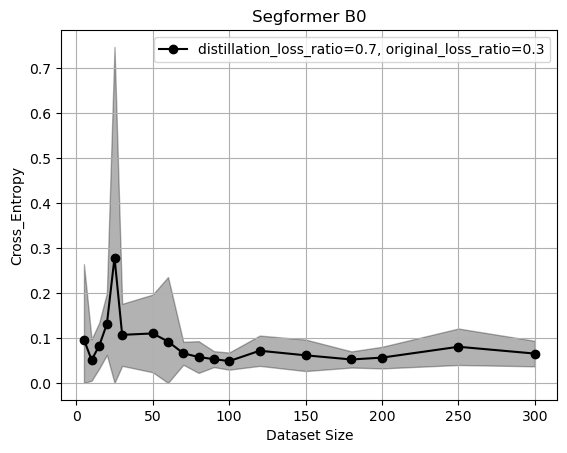

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()